In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Revision Regresión

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={"figure.figsize": (15.,8.)})

from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
vehicles = pd.read_csv('/content/sample_data/vehicles.csv', sep = ';')
vehicles.head()

,Make,Model,Year,Engine Displacement,Cylinders,Transmission,Drivetrain,Vehicle Class,Fuel Type,Fuel Barrels/Year,City MPG,Highway MPG,Combined MPG,CO2 Emission Grams/Mile,Fuel Cost/Year
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,19.388824,18.0,17,17,522.764706,1950.0
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13.0,13,13,683.615385,2550.0
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,20.600625,16.0,17,16,555.437500,2100.0
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13.0,13,13,683.615385,2550.0
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,20.600625,14.0,21,16,555.437500,2550.0


## Renombrar variables

En concreto en este conjunto de datos los nombre de las variables están escritos con espacios entre palabras y símbolos como "/". Como vimos en clases anteriores es mejor homogeneizarlos, usando "_"

También vamos a normalizar algunas variables discretas para que su uso sea más eficiente, ya que tienen muchas categorías pero muchas de ellas tienen poca representatividad: Drivetrain y Fuel type.

In [ ]:
vehicles.columns = ['Make', 'Model', 'Year', 'Engine_Displacement', 'Cylinders',
       'Transmission', 'Drivetrain', 'Vehicle_Class', 'Fuel_Type',
       'Fuel_Barrels_Year', 'City_MPG', 'Highway_MPG', 'Combined_MPG',
       'CO2_Emission_Grams_Mile', 'Fuel_Cost_Year']

In [ ]:
vehicles.groupby('Year').count()

In [ ]:
vehicles.loc[vehicles['Drivetrain'].isin(['2-Wheel Drive','2-Wheel Drive- Front','Front-Wheel Drive']), 'Traction'] = 'Wheels_2_Front'
vehicles.loc[vehicles['Drivetrain'].isin(['4-Wheel Drive','4-Wheel or All-Wheel Drive','All-Wheel Drive',
                                         'Automatic 4-spd','Part-time 4-Wheel Drive']), 'Traction'] = 'Wheels_4'
vehicles.loc[vehicles['Drivetrain'].isin(['Rear-Wheel Drive']), 'Traction'] = 'Wheels_2_Back'

vehicles.loc[vehicles['Fuel_Type'].isin(['Regular']), 'Diesel'] = 1
vehicles.loc[~(vehicles['Fuel_Type'].isin(['Regular'])), 'Diesel'] = 0


In [ ]:
vehicles

In [ ]:
vehicles.info()

## One-hot encode - Variables Dummy



Hasta ahora hemos entrenado modelos de regresión con una variable continua, pero también es posible diseñar modelos con variables discretas o categóricas.

Lo más lógico sería simplemente introducir en el modelo una de estas variables, y funcionaría.

No obstante, no sabríamos el poder discriminatorio que tiene cada una de las categorías, o si esa categorización que hemos efectuado (o no) anteriormente es la más adecuada.

Por ello vamos a crear variables binarias (variables dummy, one-hot encoding). Crearemos tantas variables como categorías tenga la variable original menos una. Ya que la última sería combinación lineal de las otras.

De manera que cada observación tomará el valor 1 en la columna correspondiente a la categoría que toma valor en el dataframe original, y 0 en el resto de columnas.

https://www.educative.io/blog/one-hot-encoding

https://medium.com/@jjosephmorrison/one-hot-encoding-to-set-up-categorical-features-for-linear-regression-6bac35661bb6

In [ ]:
vehicles_dum = pd.get_dummies(vehicles['Traction'])
vehicles_dum.head()

,Wheels_2_Back,Wheels_2_Front,Wheels_4
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [ ]:
vehicles = pd.concat([vehicles, vehicles_dum], axis = 1)
vehicles.sample(5)


,Make,Model,Year,Engine_Displacement,Cylinders,Transmission,Drivetrain,Vehicle_Class,Fuel_Type,Fuel_Barrels_Year,...,Wheels_4,Wheels_2_Back,Wheels_2_Front,Wheels_4,Wheels_2_Back,Wheels_2_Front,Wheels_4,Wheels_2_Back,Wheels_2_Front,Wheels_4
17965,Hyundai,Excel,1993,1.5,4.0,Manual 5-spd,Front-Wheel Drive,Subcompact Cars,Regular,11.771786,...,0,0,1,0,0,1,0,0,1,0
6167,Chevrolet,K10 Blazer 4WD,1986,6.2,8.0,Automatic 4-spd,4-Wheel or All-Wheel Drive,Special Purpose Vehicles,Diesel,22.481471,...,1,0,0,1,0,0,1,0,0,1
32506,Toyota,Camry,1990,2.0,4.0,Automatic 4-spd,Front-Wheel Drive,Compact Cars,Regular,13.733750,...,0,0,1,0,0,1,0,0,1,0
11084,Eagle,Summit Wagon,1995,1.8,4.0,Manual 5-spd,Front-Wheel Drive,Midsize-Large Station Wagons,Regular,14.330870,...,0,0,1,0,0,1,0,0,1,0
23798,Mercedes-Benz,CLS63 AMG,2007,6.2,8.0,Automatic (S7),Rear-Wheel Drive,Compact Cars,Premium,23.543571,...,0,1,0,0,1,0,0,1,0,0


## Datos de entrenamiento y datos de validación

Validar un modelo con los datos con los que lo que lo entrenaste no es lo más correcto. El principal problema que podemos encontrar entrenando y validando el modelo con los mismos datos es sobreajustar el modelo (overfitting). Ya que tu modelo de regresión lineal está demasiado diseñado/centrado en tus datos originales y puede no ser potente para predecir futuras observaciones.

Estas futuras observaciones son desconocidas, de ahí que lo mejor sea validar tu modelo con observaciones ajenas también.

Por lo tanto, vamos a dividir nuestro dataset en dos, uno de entrenamiento y otro de validación. Normalmente la proporción es 80%-20% respectivamente. De forma que, construyamos el modelo con "train" y calculemos los errores (MAE, MSE y RMSE) con el de "test"

https://tech.gobetech.com/15376/cual-es-la-diferencia-entre-los-datos-de-entrenamiento-y-los-datos-de-prueba.html#:~:text=La%20salida%20de%20los%20datos%20de%20entrenamiento%20est%C3%A1,son%20m%C3%A1s%20grandes%20que%20los%20datos%20de%20prueba.

In [ ]:
vehicles_train, vehicles_test = train_test_split(vehicles, test_size=0.2, random_state=0)

In [ ]:
print(vehicles_train.shape)
print(vehicles_test.shape)

(28761, 20)
(7191, 20)


## Entrenamiento del modelo

In [ ]:
vehicles.info()

In [ ]:
vehicles_train.columns

Index(['Make', 'Model', 'Year', 'Engine_Displacement', 'Cylinders',
       'Transmission', 'Drivetrain', 'Vehicle_Class', 'Fuel_Type',
       'Fuel_Barrels_Year', 'City_MPG', 'Highway_MPG', 'Combined_MPG',
       'CO2_Emission_Grams_Mile', 'Fuel_Cost_Year', 'Traction', 'Diesel',
       'Wheels_2_Back', 'Wheels_2_Front', 'Wheels_4'],
      dtype='object')

In [ ]:
ols = smf.ols("CO2_Emission_Grams_Mile ~ Fuel_Cost_Year", data = vehicles_train)
ols_fit = ols.fit()
print(ols_fit.summary())

In [ ]:
ols = smf.ols("CO2_Emission_Grams_Mile ~ CO2_Emission_Grams_Mile", data = vehicles_train) # Wheels_2_Front
ols_fit = ols.fit()
print(ols_fit.summary())

                               OLS Regression Results                              
Dep. Variable:     CO2_Emission_Grams_Mile   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 5.067e+33
Date:                     Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                             16:43:40   Log-Likelihood:             7.9007e+05
No. Observations:                    28761   AIC:                        -1.580e+06
Df Residuals:                        28759   BIC:                        -1.580e+06
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

## Validación del modelo con el conjunto de test

Del mismo modo que anteriormente, vamos medir la calidad de nuestro modelo analizando los errores. Esta vez a través del conjunto de datos de test. Es decir, vamos a comparar el valor observado de nuestra variable dependiente con el predicho.


In [ ]:
vehicles_test

In [ ]:
prediction_train = ols_fit.predict(vehicles_train)
prediction_test = ols_fit.predict(vehicles_test)
prediction_test



30627    390.323832
16302    521.836248
35663    521.836248
32242    521.836248
12098    521.836248
            ...    
17270    390.323832
14843    529.918144
202      390.323832
29470    529.918144
3487     521.836248
Length: 7191, dtype: float64

In [ ]:
print('MAE test', metrics.mean_absolute_error(vehicles_test['CO2_Emission_Grams_Mile'],prediction_test) )
print('MSE test' , metrics.mean_squared_error(vehicles_test['CO2_Emission_Grams_Mile'],prediction_test))
print('RMSE test', np.sqrt(metrics.mean_squared_error(vehicles_test['CO2_Emission_Grams_Mile'], prediction_test)))

MAE test 77.14139750982326
MSE test 10240.321057857433
RMSE test 101.19447147871979


In [ ]:
print('MAE train', metrics.mean_absolute_error(vehicles_train['CO2_Emission_Grams_Mile'],prediction_train) )
print('MSE train' , metrics.mean_squared_error(vehicles_train['CO2_Emission_Grams_Mile'],prediction_train))
print('RMSE train', np.sqrt(metrics.mean_squared_error(vehicles_train['CO2_Emission_Grams_Mile'], prediction_train)))

MAE train 76.21551598456142
MSE train 9882.355467799192
RMSE train 99.41003705762911


## Análisis de los residuos

A parte de la valdiación del modelo R2 y el cálculo de los errores (MAE...), estamos seguros de que nuestro modelo se ajusta bien a los datos? Son nuestros residuos suficientemente bajos?

Una buena manera de saberlo es ver si todos los residuos están centrados en cero, o si por el contrario existe una subpoblación para la cual el modelo no es propicio.



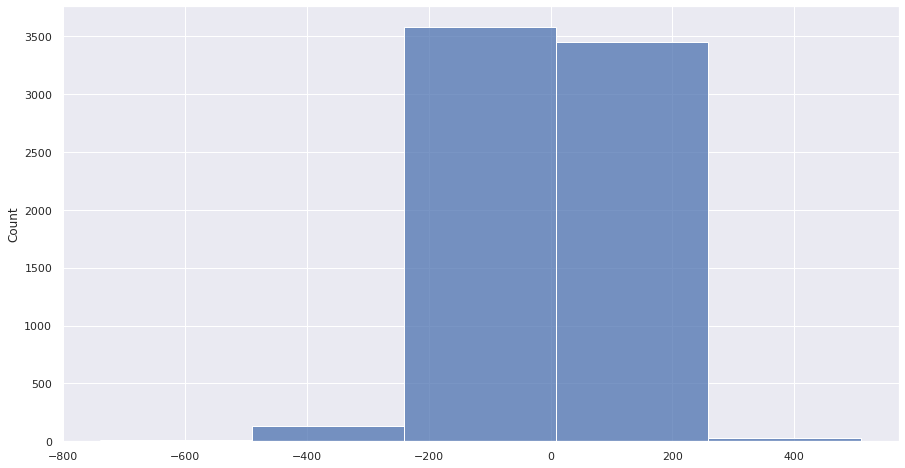

In [ ]:
vehicles_test['prediction'] = prediction_test
sns.histplot(prediction_test-vehicles_test['CO2_Emission_Grams_Mile'],bins=5);

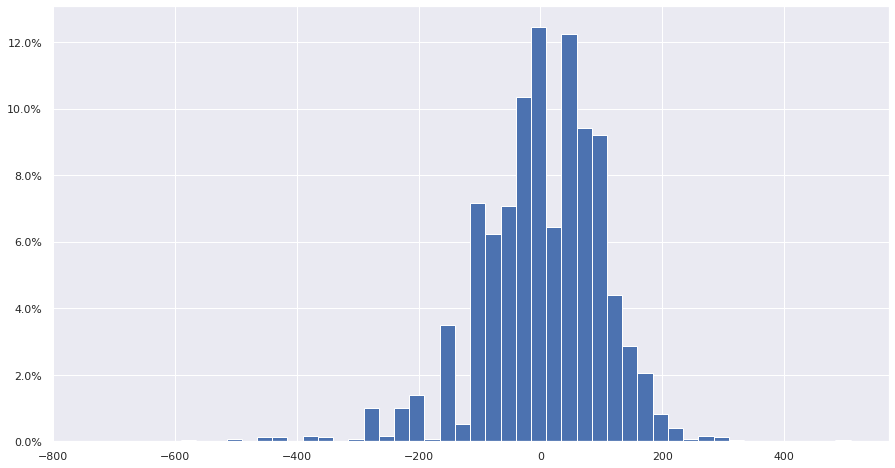

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.hist(vehicles_test['prediction']-vehicles_test['CO2_Emission_Grams_Mile'], weights=np.ones(len(vehicles_test['prediction'])) / len(vehicles_test['prediction']),bins=50)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

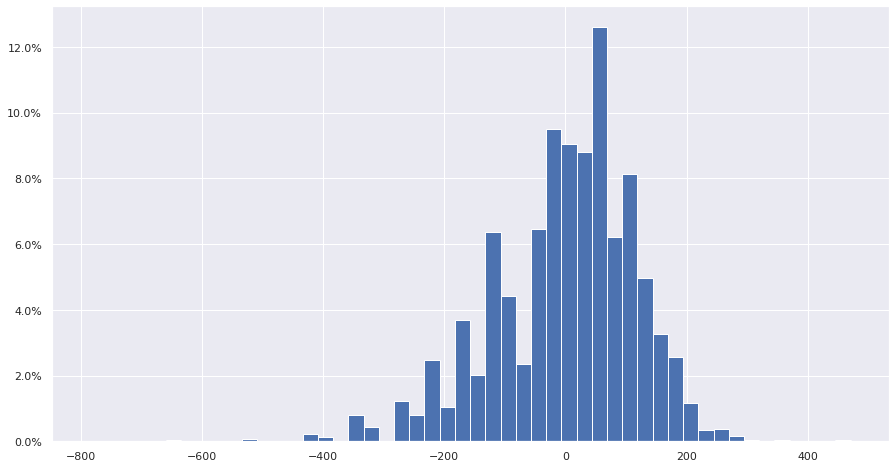

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
vehicles_train['prediction'] = prediction_train
plt.hist(vehicles_train['prediction']-vehicles_train['CO2_Emission_Grams_Mile'], weights=np.ones(len(vehicles_train['prediction'])) / len(vehicles_train['prediction']),bins=50)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
vehicles_test['residual'] = vehicles_test['CO2_Emission_Grams_Mile'] - vehicles_test['prediction']

In [ ]:
residuals_test = vehicles_test[vehicles_test['residual'] > 50]
sns.histplot(residuals_test['Fuel_Cost_Year'] )